以下是Enzyme Kinetic Extraction结果进行Data Analysis的一系列分析代码

导入所需的包

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib_venn import venn2

Part 1 - Brenda数据有误差Part 1 - Brenda数据有误差

1.1. 用Venn Diagram展示36篇random_samples上，Brenda数据和Golden数据，基于kcat/km字段line-by-line对齐后，overlap的数据行情况，面积大小直接展示行数多少（line-by-line对齐数据见data/others/20241025_brenda_golden_36_merge.xlsx），这种情况的数值展示在接下来的代码块中

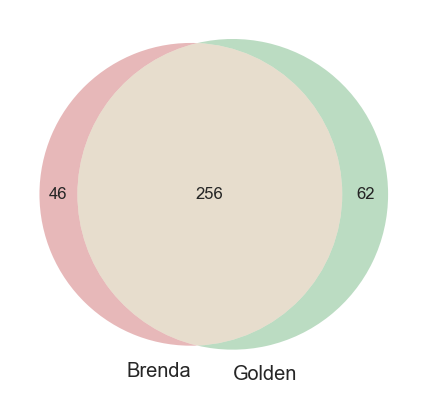

In [8]:
# 输入数据
Brenda_only = 46  # 换成对应的值
Golden_only = 256  # 换成对应的值
BG_common = 62  # 换成对应的值

# Venn Diagram
venn_labels = (Brenda_only, BG_common, Golden_only)
venn2(subsets=venn_labels, set_labels=('Brenda', 'Golden'))

plt.show()

1.2. 除了line-by-line对齐外的overlapping的情况，如总数或者分字段数据的overlapping情况，相当于将brenda数据作为一个模型，在金标准上进行测评，如果需要相应地汇报，可以根据brenda模型测评结果改动数值得到相应的图

Part 2 - 基于 expert-annotated dataset，我们ablate 其中若干关键的 design choice，比如 input format, 大语言模型，和大语言模型的超参数等

2.0. 按文件名排序处理指定文件夹中的所有 JSON 文件, 返回 F1 结果的 DataFrame, 对接后面的画图

In [3]:
def calculate_f1_from_json(json_path):
    """
    从 JSON 文件中计算 F1-score，并返回结果 DataFrame
    """
    # 读取JSON文件
    json_data = pd.read_json(json_path)

    # 将JSON数据转换为字典
    data_dict = json_data.to_dict(orient='index')

    # 不看后面total的统计部分
    filtered_data = {k: v for k, v in data_dict.items() if k != "total"}

    # 转换为转置的DataFrame
    df = pd.DataFrame.from_dict(filtered_data, orient='index').transpose()

    # 不需要最后total的这行数据，只需要前面paper-wise的数据
    df = df.drop(index='total')

    # index命名为pubmedid
    df.index.name = 'pubmedid'

    # 计算各篇上的recall值
    df['recall'] = df['total_right_num'] / (df['total_golden'] + 1e-10)

    # 计算各篇上的precision值
    df['precis'] = df['total_right_num'] / (df['total_big_model'] + 1e-10)

    # 计算 F1-score
    df['F1'] = 2 * df['recall'] * df['precis'] / (df['recall'] + df['precis'] + 1e-10)

    # golden、LLMs、和right_num都为0的情况，需要让recall、precis和F1都置1
    mask = (df['total_right_num'] == 0) & (df['total_golden'] == 0) & (df['total_big_model'] == 0)
    df.loc[mask, ['recall', 'precis', 'F1']] = 1.0

    return df[['precis', 'recall', 'F1']].reset_index()


def process_all_json_in_folder(folder_path):
    """
    按文件名排序处理指定文件夹中的所有 JSON 文件并返回 F1 结果的 DataFrame
    """
    f1_results = pd.DataFrame()

    # 获取并排序文件夹中的所有 JSON 文件
    json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

    # 每个文件计算F1-score后存入f1_results
    for filename in json_files:
        json_path = os.path.join(folder_path, filename)
        f1_df = calculate_f1_from_json(json_path)
        f1_df['file'] = filename[:-5]  # 去掉".json的字样，直接用文件名"
        f1_results = pd.concat([f1_results, f1_df], ignore_index=True)

    return f1_results

2.0. 基于F1-score数据进行swarmplot + violinplot的画图代码

In [5]:
def plot_f1_swarm(f1_results, title=None, xlabel=None, ylabel=None, category_order=None, color_from_index=0, swarm=True):
    """
    基于F1-score数据进行swarmplot + violinplot
    参数：
    f1_results (DataFrame): 包含 'F1' 和 'file' 列的 DataFrame
    """
    # 将 'file' 列转换为类别型，以便绘图时可以分组
    f1_results['file'] = pd.Categorical(f1_results['file'], categories=category_order, ordered=True)
    num_categories = len(f1_results['file'].cat.categories)

    # 设置样式
    sns.set(style="ticks")

    # 创建图形
    fig = plt.figure(figsize=(num_categories * 1.2, 4.5))

    # 调整边距
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    # palette
    palette = sns.color_palette('Set2')
    c_palette = palette[color_from_index:]

    # violin plot
    sns.violinplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
                   palette=c_palette, bw_adjust=.3, alpha=0.5,
                   inner_kws=dict(box_width=6, whis_width=2), zorder=2)

    # swarm plot
    if swarm:
        sns.swarmplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
                      palette=c_palette, size=4, zorder=1)

    # 中位数点
    sns.pointplot(
        x='file', y='F1', data=f1_results, hue='file', legend=False,
        dodge=False, linestyle="none", errorbar=None, estimator=np.median,
        marker="_", markersize=20, markeredgewidth=3,
        palette=['black'] * num_categories, zorder=3
    )

    # 均值点
    sns.pointplot(
        x='file', y='F1', data=f1_results, hue='file', legend=False,
        dodge=False, linestyle="none", errorbar=None, estimator=np.mean,
        marker="_", markersize=20, markeredgewidth=3,
        palette=['white'] * num_categories, zorder=4
    )

    # title和label及字体
    plt.xlabel(xlabel, fontsize=12)
    plt.title(title, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # 刻设置度标签的字体大小
    plt.gca().tick_params(axis='both', labelsize=12)

    # box和框线
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # 显示图
    # plt.tight_layout()
    plt.show()

    return fig

2.1. 绘制不同的温度条件下，Claude模型的F1表现的swarmplot + violinplot分布

/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/493044535.py:25: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.violinplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/493044535.py:31: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.swarmplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 46.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 44.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/

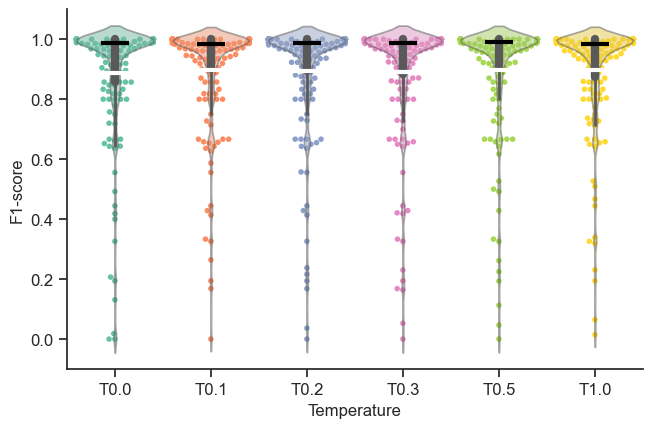

In [7]:
folder_path = 'data/params_temper_data_claude/'
f1_results = process_all_json_in_folder(folder_path)
fig = plot_f1_swarm(f1_results, xlabel='Temperature', ylabel='F1-score')

2.2. 绘制不同的Input Format条件下，Claude模型的F1表现的swarmplot + violinplot分布

/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/493044535.py:25: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.violinplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/493044535.py:31: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.swarmplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 42.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 51.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/

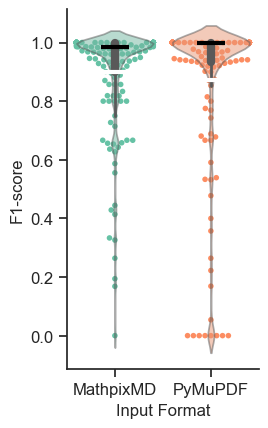

In [9]:
folder_path = 'data/params_ocr_data/'
f1_results = process_all_json_in_folder(folder_path)
fig = plot_f1_swarm(f1_results, xlabel='Input Format', ylabel='F1-score')
# 存储图
# fig.savefig('figure/fig.S3.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.S3.png', format='png', dpi=300, bbox_inches='tight')

2.3. 绘制不同的温度条件下，Claude模型和GPT-4o模型的F1表现的折线图plot

    Temperature   Model    recall    precis        F1
0           0.0  claude  0.919495  0.885499  0.888679
1           0.0  gpt-4o  0.793011  0.876381  0.805182
2           0.1  claude  0.928011  0.897917  0.899025
3           0.1  gpt-4o  0.872414   0.90648  0.870687
4           0.2  claude  0.923338  0.895408  0.895568
5           0.2  gpt-4o  0.873868   0.90212  0.869926
6           0.3  claude  0.915492  0.890791  0.890871
7           0.3  gpt-4o  0.854208  0.897966  0.854865
8           0.5  claude  0.912104   0.90604  0.896572
9           0.5  gpt-4o  0.877081  0.885696  0.863336
10          1.0  claude  0.911809  0.902559  0.896579
11          1.0  gpt-4o  0.795137  0.898636  0.812406


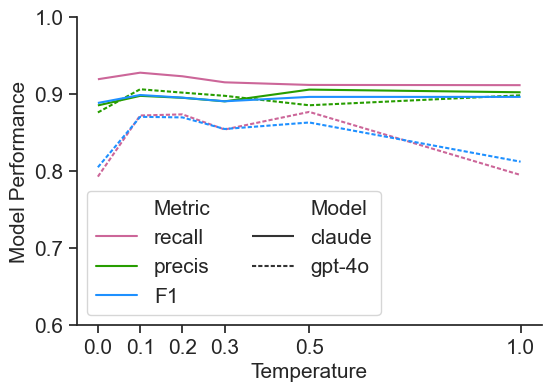

In [11]:
# 处理得到paper-wise的metrics
def process_metrics_paperwise(folder_paths):
    """
    处理提供的folder_paths下的，paperwise的，Recall、Precision、F1-score等metrics数据
    参数：
    folder_paths: 包含 存储有两个模型不同温度条件json结果的 folder_paths
    """
    df_list = []

    for folder_path in folder_paths:
        # 处理folder_path下的所有json文件得到包含 recall precis 和 F1 的 f1_results
        f1_results = process_all_json_in_folder(folder_path)

        # 提取模型信息
        model_name = folder_path.split('_')[-1].strip('/')
        f1_results['Model'] = model_name

        # 提取温度信息
        f1_results['Temperature'] = f1_results['file'].str.lstrip('T').astype(float)

        df_list.append(f1_results)

    concat_data = pd.concat(df_list, ignore_index=True)
    average_metrics = concat_data.groupby(['Temperature', 'Model']).agg({'recall': 'mean','precis': 'mean','F1': 'mean'}).reset_index()

    return average_metrics

# 处理得到entry-wise的metrics
def process_metrics_entrywise(folder_paths):
    """
    处理提供的folder_paths下的，entrywise的，Recall、Precision、F1-score等metrics数据
    参数：
    folder_paths: 包含 存储有两个模型不同温度条件json结果的 folder_paths
    """
    data = []

    # 获取并排序文件夹中的所有 JSON 文件
    for folder_path in folder_paths:
        json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

        # 每个文件计算总体F1-score后存入data
        for filename in json_files:
            json_path = os.path.join(folder_path, filename)

            # 读取JSON文件
            json_data = pd.read_json(json_path)

            # 提取数据
            total_golden = json_data['total']['total_golden']
            total_big_model = json_data['total']['total_big_model']
            total_right_num = json_data['total']['total_right_num']

            # 计算存入data
            recall = total_right_num / (total_golden + 1e-10)
            precis = total_right_num / (total_big_model + 1e-10)
            F1 = 2 * recall * precis / (recall + precis + 1e-10)

            # golden、LLMs、和right_num都为0的情况，需要让recall、precis和F1都置1
            mask = (total_right_num == 0) & (total_golden == 0) & (total_big_model == 0)
            recall[mask] = 1.0
            precis[mask] = 1.0
            F1[mask] = 1.0

            # 提取模型信息
            model_name = folder_path.split('_')[-1].strip('/')

            # 提取温度信息
            file = float(filename[1:-5])

            data.append({'Temperature': file, 'recall': recall, 'precis': precis, 'F1': F1,
                         'Model': model_name})

        # 将数据整理到 DataFrame
        df_data = pd.DataFrame(data)

    return df_data

# 绘制折线图
def plot_metric_lines(df_data):
    """
    基于df_data中的Recall、Precision、F1-score等metrics数据进行line plot，绘制折线图
    参数：
    f1_results (DataFrame): 包含 'precis', 'recall', 'F1' 和 'Temperature' 和 'Model' 列的 DataFrame
    """

    # 确保温度字段是float
    df_data['file'] = float()

    # 将数据转化为长格式，便于绘图
    df_melted = df_data.melt(id_vars=['Temperature', 'Model'], value_vars=['recall', 'precis', 'F1'],
                         var_name='Metric', value_name='Value')

    fig = plt.figure(figsize=(6, 4))
    colors = ['#CC6699', '#279D00', '#1E90FF']
    sns.lineplot(data=df_melted, x='Temperature', y='Value', hue='Metric', style='Model', palette=colors,
                 markers=False, dashes={'claude': (1, 0), 'gpt-4o': (2, 1)})

    # lims and ticks
    plt.ylim(0.60, 1.00)
    plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0], fontsize=15)
    x_values = sorted(df_data['Temperature'].unique())
    plt.xticks(x_values, [str(x) for x in x_values], fontsize=15)


    # Labels and legends
    plt.xlabel('Temperature', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)

    plt.legend(title=None, ncol=2, fontsize=15)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # box和框线
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # 显示图
    plt.show()

    return fig

# GPT-4o和Claude这两个模型的，不同温度的结果文件，存储在两个不同的文件夹中
folder_paths = ['data/params_temper_data_gpt-4o/', 'data/params_temper_data_claude/']
# df_data = process_metrics_entrywise(folder_paths)
df_data = process_metrics_paperwise(folder_paths)
print(df_data)
fig = plot_metric_lines(df_data)
# 存储图
# fig.savefig('figure/fig.S1.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.S1.png', format='png', dpi=300, bbox_inches='tight')

Part 3 - 我们设计了 aggregation agent 模块来合并不同数据, 检查F1-score的swarmplot + violinplot分布

3.1. 绘制Brenda模型的表现，F1的swarmplot + violinplot分布

/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/524449690.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_data = pd.read_json(json_path)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/524449690.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_data = pd.read_json(json_path)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/524449690.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings i

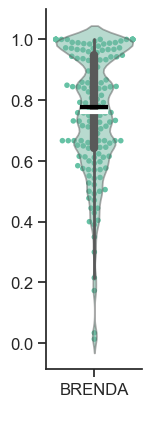

In [12]:
folder_path = 'data/brenda_data/'
f1_results = process_all_json_in_folder(folder_path)
fig = plot_f1_swarm(f1_results, xlabel=" ", ylabel=None, color_from_index=0)
# 存储图
# fig.savefig('figure/fig.2c.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.2c.png', format='png', dpi=300, bbox_inches='tight')

3.2. 绘制4个模型的表现，F1的swarmplot + violinplot分布

/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/493044535.py:25: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.violinplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/493044535.py:31: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.swarmplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 28.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 34.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/

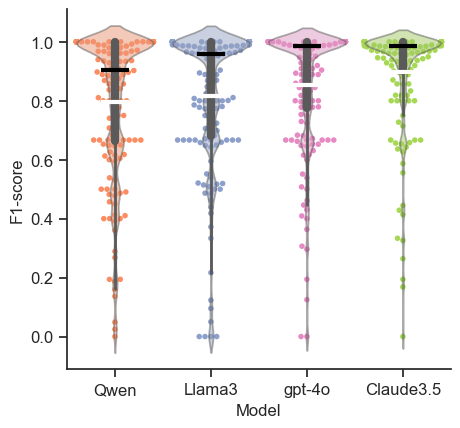

In [13]:
folder_path = 'data/llm_4_protein_enzyme_data/'
f1_results = process_all_json_in_folder(folder_path)
fig = plot_f1_swarm(f1_results, xlabel='Model', ylabel='F1-score', category_order=['Qwen', 'Llama3','gpt-4o','Claude3.5'], color_from_index=1)
# 存储图
# fig.savefig('figure/fig.2a.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.2a.png', format='png', dpi=300, bbox_inches='tight')

3.3. 绘制综合4模型aggregation agent的表现，F1的swarmplot + violinplot分布

/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/493044535.py:25: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.violinplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/493044535.py:31: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.swarmplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 48.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 50.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


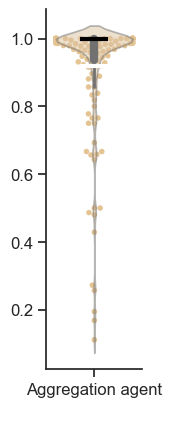

In [14]:
folder_path = 'data/aggregation_data_protein_enzyme/'
f1_results = process_all_json_in_folder(folder_path)
fig = plot_f1_swarm(f1_results, xlabel=" ", ylabel=None, color_from_index=6)
# 存储图
# fig.savefig('figure/fig.2b.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.2b.png', format='png', dpi=300, bbox_inches='tight')

3.4. 绘制ribozyme不同的模型的表现，F1的swarmplot + violinplot分布

/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/493044535.py:25: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.violinplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/493044535.py:31: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.swarmplot(x='file', y='F1', data=f1_results, hue='file', legend=False,
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 35.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/

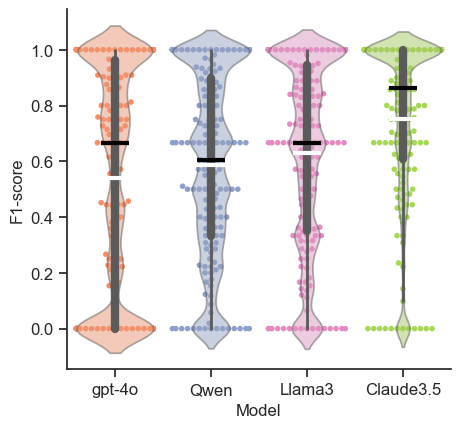

In [15]:
folder_path = 'data/llm_4_ribozyme_data/'
f1_results = process_all_json_in_folder(folder_path)
fig = plot_f1_swarm(f1_results, xlabel='Model', ylabel='F1-score', category_order=['gpt-4o','Qwen', 'Llama3','Claude3.5'], color_from_index=1)
# 存储图
# fig.savefig('figure/fig.3a.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.3a.png', format='png', dpi=300, bbox_inches='tight')

3.5. 绘制ribozyme上两个aggregation模型的表现，F1的swarmplot + violinplot分布

/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 33.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 33.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


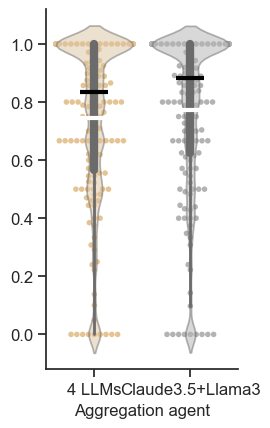

In [16]:
folder_path = 'data/aggregation_data_ribozyme/'
f1_results = process_all_json_in_folder(folder_path)
fig = plot_f1_swarm(f1_results, xlabel='Aggregation agent', ylabel=None, category_order=['4 LLMs','Claude3.5+Llama3'], color_from_index=6)
# 存储图
# fig.savefig('figure/fig.3b.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.3b.png', format='png', dpi=300, bbox_inches='tight')

Part 4 - 最终 expert-annotated dataset 上的表现

4.0. 基于single model的 JSON 文件数据，区分字段地汇报recall和paper-wise的precision和precision，以recall和precision为横纵坐标进行scatter plot画图代码

In [17]:
def plot_joint_distribution(json_path, right_field, golden_field, big_model_field, rot=-.5, plot_show=True):
    """
    基于single model的JSON文件数据，计算paper wise的recall和precision，为横纵坐标进行scatter plot
    点的大小表示Extracted Entries，点的颜色表示Benchmark Entries
    参数：
    right_field : 表示准确结果的字段名，可以是'total_right_num'，也可是分字段的'km_total_right_num'等，注意匹配
    golden_field : 表示金标准结果的字段名，可以是'total_golden'，也可是分字段的'km_total_golden'等，注意匹配
    big_model_field : 表示抽取结果的字段名，可以是'total_big_model'，也可是分字段的'km_total_big_model'等，注意匹配
    """

    # 读取 JSON 文件
    json_data = pd.read_json(json_path)

    # 将 JSON 数据转换为字典
    data_dict = json_data.to_dict(orient='index')

    # 不看后面total的统计部分
    filtered_data = {k: v for k, v in data_dict.items() if k != "total"}

    # 转换为转置的DataFrame
    data = pd.DataFrame.from_dict(filtered_data, orient='index').transpose()

    # 不需要最后total的这行数据，只需要前面paper-wise的数据
    data = data.drop(index='total')

    # index命名为pubmedid
    data.index.name = 'pubmedid'

    # 计算值
    data['recall'] = data[right_field] / (data[golden_field] + 1e-10) * 100  # unit：%
    data['precis'] = data[right_field] / (data[big_model_field] + 1e-10) * 100 # unit：%
    data['F1'] = 2 * data['recall'] * data['precis'] / (data['recall'] + data['precis'] + 1e-10) /100

    # golden、LLMs、和right_num都为0的情况，需要让recall、precis和F1都置1
    mask = (data[right_field] == 0) & (data[golden_field] == 0) & (data[big_model_field] == 0)
    data.loc[mask, ['recall', 'precis']] = 100.0
    data.loc[mask, 'F1'] = 1.0

    # 提取前缀
    prefix = right_field.split('total')[0]  # 获取 "total" 之前的内容

    # 计算统计值
    recall_mean = data['recall'].mean()/100
    precis_mean = data['precis'].mean()/100
    f1_mean = data['F1'].mean()

    # 打印结果
    print(f"{prefix}recall_mean: {recall_mean:.2f}")
    print(f"{prefix}precis_mean: {precis_mean:.2f}")
    print(f"{prefix}F1_mean: {f1_mean:.2f}")

    data['Benchmark Entries'] = data["total_golden"]
    data['Extracted Entries'] = data["total_big_model"]

    # 创建 JointGrid
    sns.set_theme(style="ticks")

    cmap = sns.cubehelix_palette(rot=rot, as_cmap=True)
    g = sns.JointGrid(data=data, x="recall", y="precis", space=0.5, ratio=5)
    g.plot_joint(sns.scatterplot, size=data["Extracted Entries"], sizes=(10, 500),
                 hue=data["Benchmark Entries"], alpha=.6, legend=True, palette=cmap)

    # 调整图例字体大小
    handles, labels = g.ax_joint.get_legend_handles_labels()
    g.ax_joint.legend(handles, labels, fontsize=9)

    # 添加边际分布（直方图）
    marginal_color = cmap(0.2)
    sns.histplot(x=data['recall'], color=marginal_color, bins=20, ax=g.ax_marg_x, alpha=1, kde=False, edgecolor=marginal_color)
    sns.histplot(y=data['precis'], color=marginal_color, bins=20, ax=g.ax_marg_y, alpha=1, kde=False, edgecolor=marginal_color)

    # 设置坐标轴的标签和标题
    g.set_axis_labels('Recall (%)', 'Precision (%)', fontsize=15)

    # 设置刻度标签的字体大小
    g.ax_joint.tick_params(axis='both', labelsize=15)

    # 设置坐标轴粗细
    spine_width = 1  # 可以自定义坐标轴的宽度
    g.ax_joint.spines['top'].set_visible(False)
    g.ax_joint.spines['right'].set_visible(False)
    g.ax_joint.spines['left'].set_linewidth(spine_width)
    g.ax_joint.spines['bottom'].set_linewidth(spine_width)

    # 设置刻度线的长度和宽度
    tick_length = 5  # 刻度线的长度
    tick_width = 1  # 刻度线的宽度

    g.ax_joint.tick_params(axis='both', which='major', length=tick_length, width=tick_width)
    g.ax_joint.tick_params(axis='both', which='minor', length=tick_length / 2, width=tick_width)

    # 边际坐标轴刻度设置
    g.ax_marg_x.tick_params(axis='both', which='major', length=tick_length, width=tick_width)
    g.ax_marg_x.tick_params(axis='both', which='minor', length=tick_length / 2, width=tick_width)
    g.ax_marg_y.tick_params(axis='both', which='major', length=tick_length, width=tick_width)
    g.ax_marg_y.tick_params(axis='both', which='minor', length=tick_length / 2, width=tick_width)

    # 调整图形的边距
    plt.tight_layout()

    # 显示图
    if plot_show:
        plt.show()
    else:
        plt.close()

4.1. Llama3.1模型在expert-annotated dataset 上的表现

In [18]:
json_path = 'data/llm_4_protein_enzyme_data/Llama3.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model', rot=-.5, plot_show=False)
plot_joint_distribution(json_path, 'km_total_right_num', 'km_total_golden', 'km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_total_right_num', 'kcat_total_golden', 'kcat_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_km_total_right_num', 'kcat_km_total_golden', 'kcat_km_total_big_model', rot=.5, plot_show=False)

recall_mean: 0.80
precis_mean: 0.89
F1_mean: 0.82
km_recall_mean: 0.83
km_precis_mean: 0.90
km_F1_mean: 0.84
kcat_recall_mean: 0.81
kcat_precis_mean: 0.89
kcat_F1_mean: 0.83
kcat_km_recall_mean: 0.79
kcat_km_precis_mean: 0.86
kcat_km_F1_mean: 0.80


4.2. Claude3.5模型在expert-annotated dataset 上的表现

In [19]:
json_path = 'data/llm_4_protein_enzyme_data/Claude3.5.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model', rot=-.5, plot_show=False)
plot_joint_distribution(json_path, 'km_total_right_num', 'km_total_golden', 'km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_total_right_num', 'kcat_total_golden', 'kcat_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_km_total_right_num', 'kcat_km_total_golden', 'kcat_km_total_big_model', rot=.5, plot_show=False)

recall_mean: 0.93
precis_mean: 0.90
F1_mean: 0.90
km_recall_mean: 0.94
km_precis_mean: 0.90
km_F1_mean: 0.91
kcat_recall_mean: 0.92
kcat_precis_mean: 0.90
kcat_F1_mean: 0.90
kcat_km_recall_mean: 0.92
kcat_km_precis_mean: 0.89
kcat_km_F1_mean: 0.89


4.3. GPT-4o模型在expert-annotated dataset 上的表现

In [20]:
json_path = 'data/llm_4_protein_enzyme_data/gpt-4o.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model', rot=-.5, plot_show=False)
plot_joint_distribution(json_path, 'km_total_right_num', 'km_total_golden', 'km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_total_right_num', 'kcat_total_golden', 'kcat_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_km_total_right_num', 'kcat_km_total_golden', 'kcat_km_total_big_model', rot=.5, plot_show=False)

recall_mean: 0.85
precis_mean: 0.90
F1_mean: 0.85
km_recall_mean: 0.88
km_precis_mean: 0.90
km_F1_mean: 0.87
kcat_recall_mean: 0.86
kcat_precis_mean: 0.90
kcat_F1_mean: 0.86
kcat_km_recall_mean: 0.84
kcat_km_precis_mean: 0.87
kcat_km_F1_mean: 0.84


4.4. Qwen模型在expert-annotated dataset 上的表现

In [21]:
json_path = 'data/llm_4_protein_enzyme_data/Qwen.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model', rot=-.5, plot_show=False)
plot_joint_distribution(json_path, 'km_total_right_num', 'km_total_golden', 'km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_total_right_num', 'kcat_total_golden', 'kcat_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_km_total_right_num', 'kcat_km_total_golden', 'kcat_km_total_big_model', rot=.5, plot_show=False)

recall_mean: 0.77
precis_mean: 0.90
F1_mean: 0.80
km_recall_mean: 0.79
km_precis_mean: 0.89
km_F1_mean: 0.81
kcat_recall_mean: 0.78
kcat_precis_mean: 0.88
kcat_F1_mean: 0.80
kcat_km_recall_mean: 0.74
kcat_km_precis_mean: 0.83
kcat_km_F1_mean: 0.76


4.5. BRENDA作为模型在expert-annotated dataset 上的表现

In [22]:
json_path = 'data/brenda_data/BRENDA.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model', rot=-.5, plot_show=False)
plot_joint_distribution(json_path, 'km_total_right_num', 'km_total_golden', 'km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_total_right_num', 'kcat_total_golden', 'kcat_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_km_total_right_num', 'kcat_km_total_golden', 'kcat_km_total_big_model', rot=.5, plot_show=False)

/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/2256319889.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_data = pd.read_json(json_path)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/2256319889.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_data = pd.read_json(json_path)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/2256319889.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing str

recall_mean: 0.80
precis_mean: 0.77
F1_mean: 0.76


/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/2256319889.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_data = pd.read_json(json_path)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/2256319889.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_data = pd.read_json(json_path)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/2256319889.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing str

km_recall_mean: 0.85
km_precis_mean: 0.83
km_F1_mean: 0.82


/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/2256319889.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_data = pd.read_json(json_path)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/2256319889.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_data = pd.read_json(json_path)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/2256319889.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing str

kcat_recall_mean: 0.81
kcat_precis_mean: 0.85
kcat_F1_mean: 0.80


/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/2256319889.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_data = pd.read_json(json_path)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/2256319889.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  json_data = pd.read_json(json_path)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/2256319889.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing str

kcat_km_recall_mean: 0.75
kcat_km_precis_mean: 0.68
kcat_km_F1_mean: 0.69


4.6. Aggregation模型在expert-annotated dataset 上的表现

In [23]:
json_path = 'data/aggregation_data_protein_enzyme/Aggregation agent.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model', rot=-.5, plot_show=False)
plot_joint_distribution(json_path, 'km_total_right_num', 'km_total_golden', 'km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_total_right_num', 'kcat_total_golden', 'kcat_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_km_total_right_num', 'kcat_km_total_golden', 'kcat_km_total_big_model', rot=.5, plot_show=False)

recall_mean: 0.94
precis_mean: 0.93
F1_mean: 0.92
km_recall_mean: 0.94
km_precis_mean: 0.93
km_F1_mean: 0.92
kcat_recall_mean: 0.94
kcat_precis_mean: 0.93
kcat_F1_mean: 0.93
kcat_km_recall_mean: 0.92
kcat_km_precis_mean: 0.90
kcat_km_F1_mean: 0.90


4.7. Llama3 模型在Ribozyme expert-annotated dataset 上的表现

In [24]:
json_path = 'data/llm_4_ribozyme_data/Llama3.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model', rot=-.5, plot_show=False)
plot_joint_distribution(json_path, 'kobs_total_right_num', 'kobs_total_golden', 'kobs_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'km_total_right_num', 'km_total_golden', 'km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_total_right_num', 'kcat_total_golden', 'kcat_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_km_total_right_num', 'kcat_km_total_golden', 'kcat_km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcleav_total_right_num', 'kcleav_total_golden', 'kcleav_total_big_model', rot=.5, plot_show=False)

recall_mean: 0.65
precis_mean: 0.67
F1_mean: 0.63
kobs_recall_mean: 0.66
kobs_precis_mean: 0.71
kobs_F1_mean: 0.66
km_recall_mean: 0.88
km_precis_mean: 0.87
km_F1_mean: 0.87
kcat_recall_mean: 0.86
kcat_precis_mean: 0.85
kcat_F1_mean: 0.85
kcat_km_recall_mean: 0.82
kcat_km_precis_mean: 0.82
kcat_km_F1_mean: 0.81
kcleav_recall_mean: 0.91
kcleav_precis_mean: 0.91
kcleav_F1_mean: 0.91


4.8. Claude3.5 模型在Ribozyme expert-annotated dataset 上的表现

In [25]:
json_path = 'data/llm_4_ribozyme_data/Claude3.5.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model', rot=-.5, plot_show=False)
plot_joint_distribution(json_path, 'kobs_total_right_num', 'kobs_total_golden', 'kobs_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'km_total_right_num', 'km_total_golden', 'km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_total_right_num', 'kcat_total_golden', 'kcat_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_km_total_right_num', 'kcat_km_total_golden', 'kcat_km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcleav_total_right_num', 'kcleav_total_golden', 'kcleav_total_big_model', rot=.5, plot_show=False)

recall_mean: 0.80
precis_mean: 0.75
F1_mean: 0.75
kobs_recall_mean: 0.79
kobs_precis_mean: 0.78
kobs_F1_mean: 0.76
km_recall_mean: 0.90
km_precis_mean: 0.88
km_F1_mean: 0.88
kcat_recall_mean: 0.89
kcat_precis_mean: 0.91
kcat_F1_mean: 0.89
kcat_km_recall_mean: 0.89
kcat_km_precis_mean: 0.90
kcat_km_F1_mean: 0.89
kcleav_recall_mean: 0.90
kcleav_precis_mean: 0.90
kcleav_F1_mean: 0.90


4.9. gpt-4o 模型在Ribozyme expert-annotated dataset 上的表现

In [26]:
json_path = 'data/llm_4_ribozyme_data/gpt-4o.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model', rot=-.5, plot_show=False)
plot_joint_distribution(json_path, 'kobs_total_right_num', 'kobs_total_golden', 'kobs_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'km_total_right_num', 'km_total_golden', 'km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_total_right_num', 'kcat_total_golden', 'kcat_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_km_total_right_num', 'kcat_km_total_golden', 'kcat_km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcleav_total_right_num', 'kcleav_total_golden', 'kcleav_total_big_model', rot=.5, plot_show=False)

recall_mean: 0.53
precis_mean: 0.61
F1_mean: 0.54
kobs_recall_mean: 0.57
kobs_precis_mean: 0.65
kobs_F1_mean: 0.59
km_recall_mean: 0.87
km_precis_mean: 0.88
km_F1_mean: 0.87
kcat_recall_mean: 0.85
kcat_precis_mean: 0.87
kcat_F1_mean: 0.85
kcat_km_recall_mean: 0.85
kcat_km_precis_mean: 0.87
kcat_km_F1_mean: 0.86
kcleav_recall_mean: 0.92
kcleav_precis_mean: 0.91
kcleav_F1_mean: 0.92


4.10. Qwen 模型在Ribozyme expert-annotated dataset 上的表现

In [27]:
json_path = 'data/llm_4_ribozyme_data/Qwen.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model', rot=-.5, plot_show=False)
plot_joint_distribution(json_path, 'kobs_total_right_num', 'kobs_total_golden', 'kobs_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'km_total_right_num', 'km_total_golden', 'km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_total_right_num', 'kcat_total_golden', 'kcat_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_km_total_right_num', 'kcat_km_total_golden', 'kcat_km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcleav_total_right_num', 'kcleav_total_golden', 'kcleav_total_big_model', rot=.5, plot_show=False)

recall_mean: 0.67
precis_mean: 0.60
F1_mean: 0.59
kobs_recall_mean: 0.67
kobs_precis_mean: 0.68
kobs_F1_mean: 0.63
km_recall_mean: 0.89
km_precis_mean: 0.86
km_F1_mean: 0.86
kcat_recall_mean: 0.82
kcat_precis_mean: 0.80
kcat_F1_mean: 0.80
kcat_km_recall_mean: 0.75
kcat_km_precis_mean: 0.75
kcat_km_F1_mean: 0.75
kcleav_recall_mean: 0.81
kcleav_precis_mean: 0.80
kcleav_F1_mean: 0.80


4.11. Aggre-4LLMs 模型在Ribozyme expert-annotated dataset 上的表现

In [28]:
json_path = 'data/aggregation_data_ribozyme/4 LLMs.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model', rot=-.5, plot_show=False)
plot_joint_distribution(json_path, 'kobs_total_right_num', 'kobs_total_golden', 'kobs_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'km_total_right_num', 'km_total_golden', 'km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_total_right_num', 'kcat_total_golden', 'kcat_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_km_total_right_num', 'kcat_km_total_golden', 'kcat_km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcleav_total_right_num', 'kcleav_total_golden', 'kcleav_total_big_model', rot=.5, plot_show=False)

recall_mean: 0.81
precis_mean: 0.74
F1_mean: 0.74
kobs_recall_mean: 0.80
kobs_precis_mean: 0.80
kobs_F1_mean: 0.77
km_recall_mean: 0.89
km_precis_mean: 0.87
km_F1_mean: 0.87
kcat_recall_mean: 0.89
kcat_precis_mean: 0.89
kcat_F1_mean: 0.88
kcat_km_recall_mean: 0.86
kcat_km_precis_mean: 0.86
kcat_km_F1_mean: 0.86
kcleav_recall_mean: 0.90
kcleav_precis_mean: 0.89
kcleav_F1_mean: 0.89


4.12. Aggre-Claude3.5+Llama3 模型在Ribozyme expert-annotated dataset 上的表现

In [29]:
json_path = 'data/aggregation_data_ribozyme/Claude3.5+Llama3.json'

plot_joint_distribution(json_path, 'total_right_num', 'total_golden', 'total_big_model', rot=-.5, plot_show=False)
plot_joint_distribution(json_path, 'kobs_total_right_num', 'kobs_total_golden', 'kobs_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'km_total_right_num', 'km_total_golden', 'km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_total_right_num', 'kcat_total_golden', 'kcat_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcat_km_total_right_num', 'kcat_km_total_golden', 'kcat_km_total_big_model', rot=.5, plot_show=False)
plot_joint_distribution(json_path, 'kcleav_total_right_num', 'kcleav_total_golden', 'kcleav_total_big_model', rot=.5, plot_show=False)

recall_mean: 0.83
precis_mean: 0.76
F1_mean: 0.77
kobs_recall_mean: 0.80
kobs_precis_mean: 0.79
kobs_F1_mean: 0.78
km_recall_mean: 0.89
km_precis_mean: 0.87
km_F1_mean: 0.87
kcat_recall_mean: 0.91
kcat_precis_mean: 0.93
kcat_F1_mean: 0.91
kcat_km_recall_mean: 0.88
kcat_km_precis_mean: 0.89
kcat_km_F1_mean: 0.88
kcleav_recall_mean: 0.89
kcleav_precis_mean: 0.89
kcleav_F1_mean: 0.89


Part 5 - 考察 最终 expert-annotated dataset 上的表现 和 输入tokens长度的关系

5.0. F1_f(tokens)分析画图代码

In [30]:
def plot_histogram_of_token(token_path):
    """
    基于 全量数据 的tokens长度.csv, 绘制token分布的histogram
    参数：
    token_path (path): 包含 全量数据 tokens 长度结果的 csv_path，表里需要有'id'列 和 'tokens'列 对应的数据
    """

    # 获取总token表
    token_data = pd.read_csv(token_path)

    # 统计token大于一定量的总篇数
    print((token_data['tokens']>32000).sum(), ' papers with token larger than 32k')

    # 求 tokens 以10为底的 对数
    token_data['log10_token'] = np.log10(token_data['tokens'])

    # 设置样式
    sns.set(style="ticks")

    # 创建图形
    fig = plt.figure(figsize=(5, 4))

    # 绘制histogram
    sns.histplot(data=token_data, x='log10_token', kde=True)

    # title和label及字体
    plt.xlabel("log10_token", fontsize=12)
    plt.title("", fontsize=12)
    plt.ylabel("Count", fontsize=12)

    # 刻设置度标签的字体大小
    plt.gca().tick_params(axis='both', labelsize=12)

    # box和框线
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # xlim
    plt.xlim(3.0, 6.0)
    # 显示图
    plt.show()

    return fig


def get_f1_with_token(json_path, token_path):
    """
    基于 Annotated数据在golden上测评的结果，和 全量数据 的tokens长度.csv, 整合成一张带有 tokens 和 F1 对应的 df_token
    参数：
    json_path (path): 包含 single model 测评结果的 json_path
    token_path (path): 包含 全量数据 tokens 长度结果的 csv_path，表里需要有'id'列 和 'tokens'列 对应的数据
    """

    # 计算得到 F1-score
    f1_result = calculate_f1_from_json(json_path)

    # 获取总token表
    token_data = pd.read_csv(token_path)

    # 将 token_data 的 id 列统一为字符串格式
    token_data['id'] = token_data['id'].astype(str)

    # 提取 pubmedid 中的数字部分
    f1_result['id'] = f1_result['pubmedid'].str.extract(r'(\d+)')[0].astype(str)

    # 合并数据框
    df_token = pd.merge(token_data, f1_result, left_on='id', right_on='id', how='inner')

    # 转变数据类型从object到数值型
    df_token['F1'] = pd.to_numeric(df_token['F1'], errors='coerce')

    return df_token

def plot_regression_f1_golden_tokens(df):

    """
    基于annotated数据分别在golden上测评的结果，绘制f1_golden_f(tokens)的regression plot
    参数：
    df (DataFrame): 包含by paper 的 'F1_golden'列 和 'tokens'列 的 DataFrame
    """

    # 求 tokens 以10为底的 对数
    df['log10_token'] = np.log10(df['tokens'])

    # 设置样式
    sns.set(style="ticks")

    # 创建图形
    plt.figure(figsize=(5, 4))

    g = sns.jointplot(x="log10_token", y='F1', data=df,
                      kind="reg", truncate=False,
                      xlim=(df['log10_token'].min(), df['log10_token'].max()), ylim=(-0.1, 1.1),
                      color="m")

    # 设置坐标轴的标签和标题
    g.set_axis_labels('Log10(tokens)', 'F1-score', fontsize=15)

    # 调整图例字体大小
    handles, labels = g.ax_joint.get_legend_handles_labels()
    g.ax_joint.legend(handles, labels, fontsize=9)

    # 设置刻度标签的字体大小
    g.ax_joint.tick_params(axis='both', labelsize=15)

    # 设置坐标轴粗细
    spine_width = 1  # 可以自定义坐标轴的宽度
    g.ax_joint.spines['top'].set_visible(False)
    g.ax_joint.spines['right'].set_visible(False)
    g.ax_joint.spines['left'].set_linewidth(spine_width)
    g.ax_joint.spines['bottom'].set_linewidth(spine_width)

    # 设置刻度线的长度和宽度
    tick_length = 5  # 刻度线的长度
    tick_width = 1  # 刻度线的宽度

    g.ax_joint.tick_params(axis='both', which='major', length=tick_length, width=tick_width)
    g.ax_joint.tick_params(axis='both', which='minor', length=tick_length / 2, width=tick_width)

    # 边际坐标轴刻度设置
    g.ax_marg_x.tick_params(axis='both', which='major', length=tick_length, width=tick_width)
    g.ax_marg_x.tick_params(axis='both', which='minor', length=tick_length / 2, width=tick_width)
    g.ax_marg_y.tick_params(axis='both', which='major', length=tick_length, width=tick_width)
    g.ax_marg_y.tick_params(axis='both', which='minor', length=tick_length / 2, width=tick_width)

    # 调整图形的边距
    plt.tight_layout()

    # 显示图形
    plt.show()

    return g

5.1.1. 考察Protein Enzyme上tokens的分布

374  papers with token larger than 32k


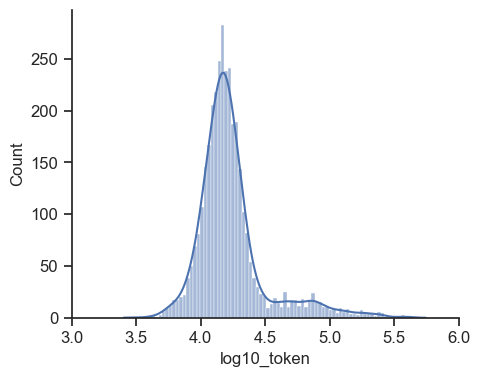

In [31]:
token_path = 'data/token_length/Protein_enzyme_cal_tokens.csv'
fig = plot_histogram_of_token(token_path)
# 存储图
# fig.savefig('figure/fig.S2d.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.S2d.png', format='png', dpi=300, bbox_inches='tight')

5.1.2.  考察Ribozyme上tokens的分布

14  papers with token larger than 32k


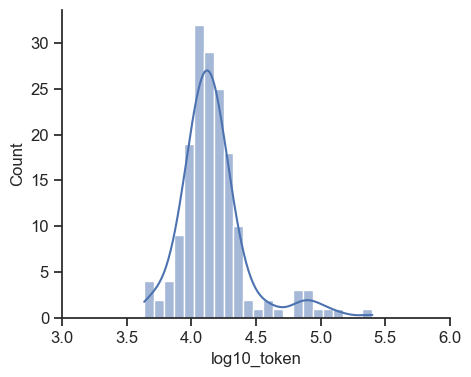

In [32]:
token_path = 'data/token_length/Ribozyme_cal_tokens.csv'
fig = plot_histogram_of_token(token_path)
# 存储图
# fig.savefig('figure/fig.S2e.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.S2e.png', format='png', dpi=300, bbox_inches='tight')

5.2. 考察Protein Enzyme上最优模型Claude@0.1的表现 _f(tokens)

<Figure size 500x400 with 0 Axes>

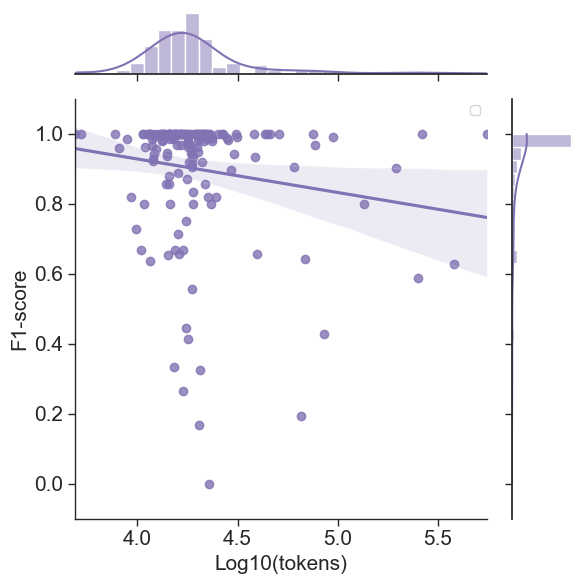

In [35]:
json_path = 'data/llm_4_protein_enzyme_data/Claude3.5.json'
token_path = 'data/token_length/Protein_enzyme_cal_tokens.csv'
df_token = get_f1_with_token(json_path, token_path)
fig = plot_regression_f1_golden_tokens(df_token)
# 存储图
# fig.savefig('figure/fig.5d-claude.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.5d-claude.png', format='png', dpi=300, bbox_inches='tight')

5.3. 考察Ribozyme上最优模型Claude@0.1的表现 _f(tokens)

<Figure size 500x400 with 0 Axes>

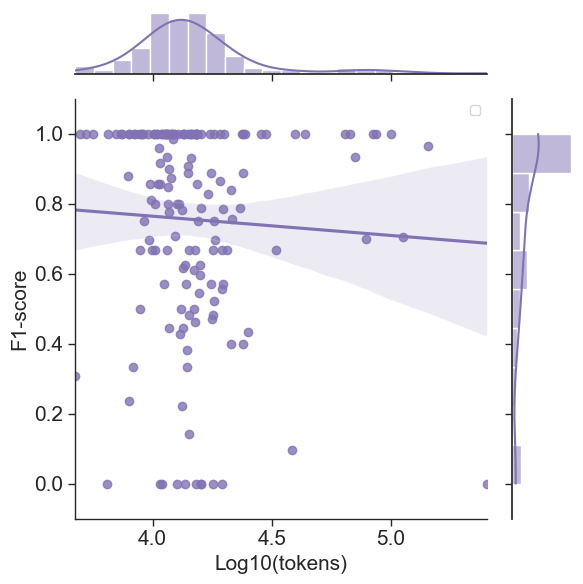

In [36]:
json_path = 'data/llm_4_ribozyme_data/Claude3.5.json'
token_path = 'data/token_length/Ribozyme_cal_tokens.csv'
df_token = get_f1_with_token(json_path, token_path)
fig = plot_regression_f1_golden_tokens(df_token)
# 存储图
# fig.savefig('figure/fig.5e-claude.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.5e-claude.png', format='png', dpi=300, bbox_inches='tight')

5.4. 考察Protein Enzyme上整理pipeline的表现 _f(tokens)

<Figure size 500x400 with 0 Axes>

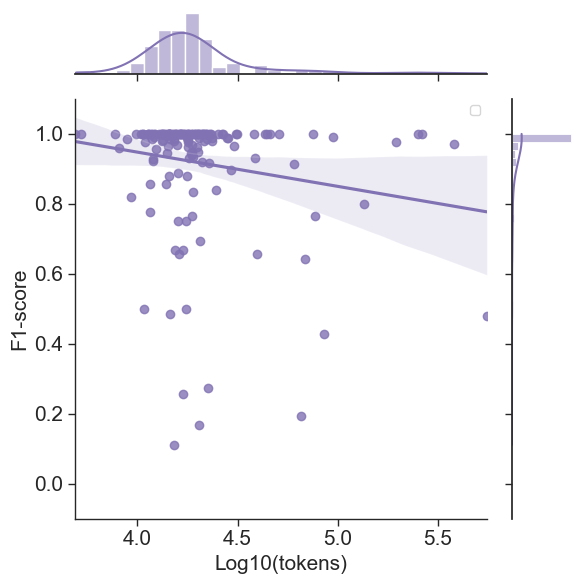

In [37]:
json_path = 'data/aggregation_data_protein_enzyme/Aggregation agent.json'
token_path = 'data/token_length/Protein_enzyme_cal_tokens.csv'
df_token = get_f1_with_token(json_path, token_path)
fig = plot_regression_f1_golden_tokens(df_token)
# 存储图
# fig.savefig('figure/fig.5d-aggre.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.5d-aggre.png', format='png', dpi=300, bbox_inches='tight')

5.5. 考察Ribozyme整体pipeline的表现 _f(tokens)

<Figure size 500x400 with 0 Axes>

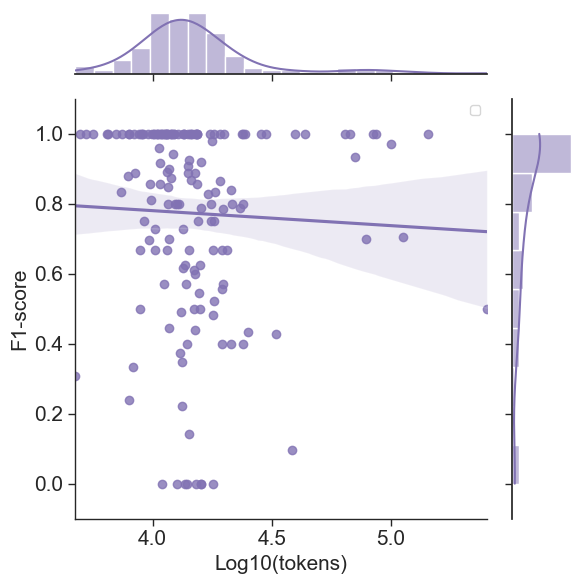

In [38]:
json_path = 'data/aggregation_data_ribozyme/Claude3.5+Llama3.json'
token_path = 'data/token_length/Ribozyme_cal_tokens.csv'
df_token = get_f1_with_token(json_path, token_path)
fig = plot_regression_f1_golden_tokens(df_token)
# 存储图
# fig.savefig('figure/fig.5e-llama-claude.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.5e-llama-claude.png', format='png', dpi=300, bbox_inches='tight')

Part 6 - Entire dataset 上的表现

6.0. 展示从annotated 到 entire dataset 推广的 split violin plot 代码

In [39]:
def process_combined_data(brenda_3435, golden_156):
    """
    基于 全量数据在brenda上测评的结果和156篇annotated数据在golden上测评的结果，整合一张全量的 combined_data dataframe for further plot
    参数：
    brenda_3435 (DataFrame): 包含 'F1' 列的 DataFrame
    golden_156 (DataFrame): 包含 'F1' 列的 DataFrame
    """

    # 添加 eval_on 列, 表示结果来自于 和哪个标准进行比较的 结果
    brenda_3435['eval_on'] = 'brenda'
    golden_156['eval_on'] = 'golden'

    # 处理 brenda_3435 数据，添加 dataset 列
    brenda_data = brenda_3435[['F1', 'eval_on']].copy()
    brenda_data['dataset'] = 'Entire'

    # 处理 golden_156 数据，添加 dataset 列
    golden_data = golden_156[['F1', 'eval_on']].copy()
    golden_data['dataset'] = 'Annotated'

    # 合并 brenda 和 golden 数据
    combined_data = pd.concat([brenda_data, golden_data], axis=0)

    # 因为是包含关系，找到共有的 pubmedid，实际上就是156的pubmedid
    common_pubmedid = brenda_3435.index.intersection(golden_156.index)

    # 156的标记为'annotated'，其他的不管继续为'entire'
    for index in common_pubmedid:
        combined_data.loc[combined_data.index == index, 'dataset'] = 'Annotated'

    # 设置顺序，不然画图的时候entire会画到上面去
    combined_data['dataset'] = pd.Categorical(combined_data['dataset'], categories=['Annotated', 'Entire'], ordered=True)
    combined_data.reset_index()

    return combined_data


def plot_f1_split_violin(total_df, title=None, xlabel='F1-score', ylabel='Dataset'):
    """
    基于 evaluated on Brenda/Golden * entire/annotated dataset 上的F1 的horizontal split violin plot
    参数：
    total_df (DataFrame): 包含 'F1' ,'eval_on' 和 'dataset' 列的 DataFrame
    """
    # 设置样式
    sns.set(style="ticks")

    # 创建图形
    fig = plt.figure(figsize=(5, 4))

    # violin plot
    sns.violinplot(y='dataset', x='F1', hue='eval_on', data=total_df, alpha=.5, palette='Set1', bw_adjust=.3, split=True, inner='quart',orient='h',gap=0.1)

    # title和labels
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)

    # 设置刻度标签的字体大小
    plt.gca().tick_params(axis='both', labelsize=15)

    # box和框线
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # 显示图表
    plt.tight_layout()
    plt.show()

    return fig


def process_aligned_data(brenda_3435, golden_156):
    """
    基于 全量数据在brenda上测评的结果和156篇annotated数据在golden上测评的结果，整合一张仅包含annotated数据的 brenda和 golden 数据 aligned_data dataframe
    参数：
    brenda_3435 (DataFrame): 包含 'F1' 列的 DataFrame
    golden_156 (DataFrame): 包含 'F1' 列的 DataFrame
    """

     # 合并两个 DataFrame
    merged_df = pd.merge(golden_156[['pubmedid', 'F1']],
                          brenda_3435[['pubmedid', 'F1']],
                          on='pubmedid',
                          suffixes=('_golden', '_brenda'))

    return merged_df


def plot_individual_f1_golden_f1_brenda(df):
    """
    基于annotated数据分别在brenda和在golden上测评的结果，绘制f1_golden和f1_brenda之间一一对应的individual plot
    参数：
    df (DataFrame): 包含by paper对应的 'F1_brenda' 列 和 'F1_golden' 列 的 DataFrame
    """

    # 以下画图
    fig = plt.figure(figsize=(5, 4))

    # 设置颜色
    colors = colormaps['Set1']  # 使用 Set1 配色方案，和前文的split_violin plot 以及后面的swarmplot中使用的 一致

    # 绘制连接线
    plt.plot([[-0.2]*len(df), [1.2]*len(df)], [df['F1_brenda'], df['F1_golden']], color='lightgray', linestyle='-', linewidth=1, zorder=1)

    # 绘制分散点
    df_melted = df.melt(value_vars=['F1_brenda', 'F1_golden'], var_name='eval_on', value_name='F1')
    sns.swarmplot(data=df_melted, x='eval_on', y='F1', hue='eval_on', palette=[colors(0), colors(1)], size=4, alpha=.5, dodge=True, zorder=2)

    # 标题标签和范围
    plt.title('Comparison of F1 Scores: F1_brenda vs F1_golden', fontsize=15)
    plt.xticks([-0.2, 1.2], ['Brenda', 'Golden'], fontsize=15)
    plt.xlabel('Evaluation benchmark', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.xlim(-1, 2)

    # 设置刻度标签的字体大小
    plt.gca().tick_params(axis='both', labelsize=15)

    # box和框线
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # 显示图形
    plt.show()

    return fig


def plot_regression_f1_golden_f1_brenda(df, fit_method='linear'):
    """
    基于annotated数据分别在brenda和在golden上测评的结果，绘制f1_golden_f(f1_brenda)的regression scatter plot
    参数：
    df (DataFrame): 包含by paper对应的 'F1_brenda' 列 和 'F1_golden' 列 的 DataFrame
    """

    # 转变数据类型从object到数值型
    df['F1_brenda'] = pd.to_numeric(df['F1_brenda'], errors='coerce')
    df['F1_golden'] = pd.to_numeric(df['F1_golden'], errors='coerce')

    # 设置样式
    sns.set(style="ticks")

    fig = plt.figure(figsize=(5, 4))
    cmap = sns.cubehelix_palette(rot=.5, as_cmap=True)

    if fit_method == 'linear':
        # 拟合 线性 回归模型
        model = sm.OLS(df['F1_golden'], sm.add_constant(df['F1_brenda']))  # 拟合模型
        results = model.fit()
        print(results.summary())

        # 绘制线性回归图
        sns.regplot(x='F1_brenda', y='F1_golden', data=df, ci=95, color=cmap(0.5), label='Linear Regression')
        plt.title('Linear Regression of F1_Golden against F1_Brenda', fontsize=15)

    elif fit_method == 'beta':
        #计算Beta回归的f1_golden_f(f1_brenda)数值
        N = len(df)
        df['F1_golden_transformed'] = (df['F1_golden'] * (N - 1) + 0.5) / N  # F1_golden 的值会被平滑地调整到 (0, 1) 的范围内，而不是[0, 1]

        # 拟合 Beta 回归模型
        model = sm.GLM(df['F1_golden_transformed'], sm.add_constant(df['F1_brenda']), family=sm.families.Binomial())
        results = model.fit()
        print(results.summary())

        # 生成一系列的值用于绘制连续回归线
        linspace_values = np.linspace(df['F1_brenda'].min(), df['F1_brenda'].max(), 100)
        linspace_values_with_const = sm.add_constant(linspace_values)

        # 模型预测的值及置信区间
        predictions = results.get_prediction(linspace_values_with_const)
        predictions_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

        # 反变换预测值为 F1_golden 的范围
        predictions_transformed = predictions_summary['mean']
        lower_bounds_transformed = predictions_summary['mean_ci_lower']  # 使用mean_ci_lower
        upper_bounds_transformed = predictions_summary['mean_ci_upper']  # 使用mean_ci_upper

        predictions = (predictions_transformed * N) / (N - 1)  # 反转之前进行的平滑调整
        lower_bounds = (lower_bounds_transformed * N) / (N - 1)
        upper_bounds = (upper_bounds_transformed * N) / (N - 1)

        # 绘制 Beta 回归线和置信区间
        plt.plot(linspace_values, predictions, color=cmap(0.5), label='Regression Line')
        plt.fill_between(linspace_values, lower_bounds, upper_bounds, color=cmap(0.5), alpha=0.2, label='95% CI')
        plt.title('Beta Regression of F1_Golden against F1_Brenda', fontsize=15)

    # scatterplot 根据 'F1_golden' 进行颜色递进，F1_golden值越大的颜色越深
    sns.scatterplot(x='F1_brenda', y='F1_golden', hue='F1_golden', palette=cmap, data=df,
                    s=50, edgecolor='w', legend=None)

    plt.xlabel('Brenda F1 Score', fontsize=15)
    plt.ylabel('Golden F1 Score', fontsize=15)

    # 设置刻度标签的字体大小
    plt.gca().tick_params(axis='both', labelsize=15)

    # box和框线
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.axis('equal')
    plt.show()

    return fig


def stats_2samp(sample1, sample2):
    """
    对sample1, sample2进行Kolmogorov-Smirnov检验和Anderson-Darling检验
    """
    alpha = 0.05

    # Kolmogorov-Smirnov检验
    ks_statistic, ks_p_value = stats.ks_2samp(sample1, sample2)
    print(f"Kolmogorov-Smirnov Statistic: {ks_statistic}, P-value: {ks_p_value}")

    # 根据p值判断是否拒绝零假设
    if ks_p_value < alpha:
        print("拒绝零假设：两个样本的分布存在显著差异")
    else:
        print("未能拒绝零假设：没有足够证据表明两个样本的分布存在显著差异")

    # Anderson-Darling检验
    method = stats.PermutationMethod(n_resamples=100)
    result = stats.anderson_ksamp([sample1, sample2], method=method)
    print(f"Anderson-Darling Statistic: {result.statistic}, P-value: {result.significance_level}")

    # 根据p值判断是否拒绝零假设
    if result.significance_level < alpha:
        print("拒绝零假设：两个样本的分布存在显著差异")
    else:
        print("未能拒绝零假设：没有足够证据表明两个样本的分布存在显著差异")

6.1.1. Claude模型在entire dataset上的表现

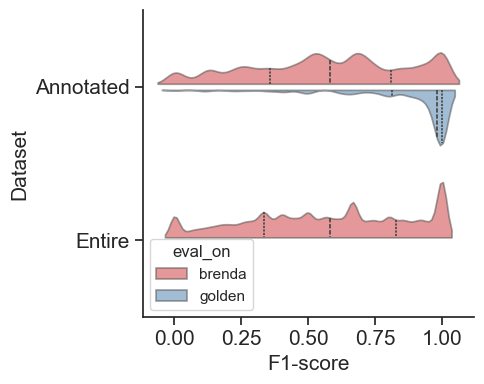

Kolmogorov-Smirnov Statistic: 0.05456635465784597, P-value: 0.7447904208423252
未能拒绝零假设：没有足够证据表明两个样本的分布存在显著差异
Anderson-Darling Statistic: -0.8721491219752573, P-value: 0.9603960396039604
未能拒绝零假设：没有足够证据表明两个样本的分布存在显著差异


In [40]:
json_path = 'data/entire_dataset_data/3450_brenda.json'
brenda_3435 = calculate_f1_from_json(json_path)
# brenda_3435.to_csv('brenda_3435.csv')  # claude_brenda_3435
json_path = 'data/entire_dataset_data/3450_golden.json'
golden_156 = calculate_f1_from_json(json_path)  # 因为金标准只有156篇，所以这里是156篇的结果
# golden_156.to_csv('golden_156.csv')  # claude_golden_156

combined_data = process_combined_data(brenda_3435, golden_156)

# 绘制split_violin plot，来展示从annotated 到 entire dataset 的推广
fig = plot_f1_split_violin(combined_data)
# 存储图
# fig.savefig('figure/fig.2e.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.2e.png', format='png', dpi=300, bbox_inches='tight')

# 假设检验Annotated eval_on Brenda 和 Entire eval_on Brenda 是否符合同一个分布
sample1 = combined_data[(combined_data['eval_on'] == 'brenda') & (combined_data['dataset'] == 'Annotated')]['F1']
sample2 = combined_data[(combined_data['eval_on'] == 'brenda') & (combined_data['dataset'] == 'Entire')]['F1']
stats_2samp(sample1, sample2)

6.1.2. 绘制violin plot for Brenda-estimated data on 156 and on the entire dataset

/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/1864715081.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1_results.rename(columns={'dataset': 'file'}, inplace=True)  # 修改列名
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/493044535.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1_results['file'] = pd.Categorical(f1_results['file'], categories=category_order, ordered=True)
/var/folders/gh/dlx7b8px6xv9d7n3t9flwqmc0000gn/T/ipykernel_38591/493044535.py:25: UserWarning: The palette list has more values (8) than needed (2),

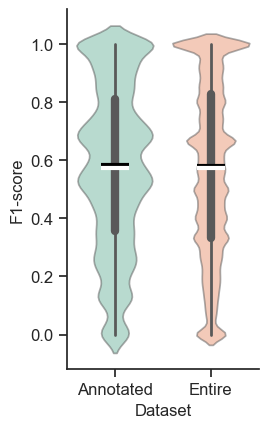

In [41]:
# 绘制violin plot for Brenda data on 156 and on the entire dataset
f1_results = combined_data[combined_data['eval_on'] == 'brenda']  # 只看BRENDA
f1_results.rename(columns={'dataset': 'file'}, inplace=True)  # 修改列名
fig = plot_f1_swarm(f1_results, xlabel='Dataset', ylabel='F1-score',swarm=False)
# 存储图
# fig.savefig('figure/fig.S4.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.S4.png', format='png', dpi=300, bbox_inches='tight')

6.2. 绘制f1_golden_f(f1_brenda)的regression scatter plot

                            OLS Regression Results                            
Dep. Variable:              F1_golden   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     65.86
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           1.43e-13
Time:                        10:43:01   Log-Likelihood:                 46.306
No. Observations:                 156   AIC:                            -88.61
Df Residuals:                     154   BIC:                            -82.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5574      0.041     13.617      0.0

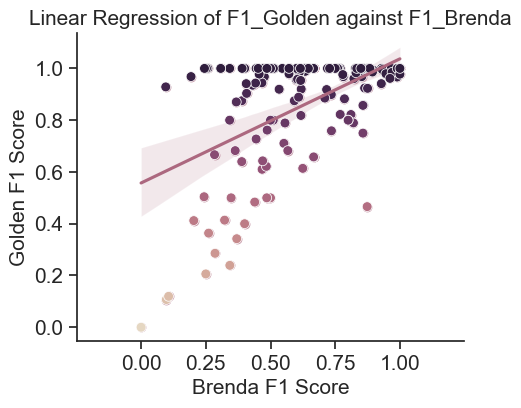

                   Generalized Linear Model Regression Results                   
Dep. Variable:     F1_golden_transformed   No. Observations:                  156
Model:                               GLM   Df Residuals:                      154
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -41.461
Date:                   Fri, 28 Feb 2025   Deviance:                       33.197
Time:                           10:43:01   Pearson chi2:                     35.9
No. Iterations:                        6   Pseudo R-squ. (CS):             0.1125
Covariance Type:               nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5995 

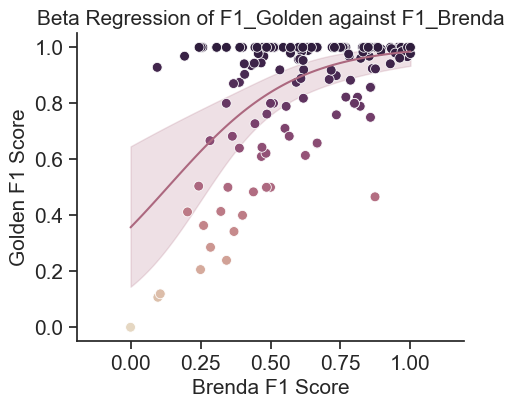

In [42]:
merged_df = process_aligned_data(brenda_3435, golden_156)
# 线性回归
fig = plot_regression_f1_golden_f1_brenda(merged_df, fit_method='linear')
# fig.savefig('figure/fig.2f-linear.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.2f-linear.png', format='png', dpi=300, bbox_inches='tight')

# beta回归
fig = plot_regression_f1_golden_f1_brenda(merged_df, fit_method='beta')
# fig.savefig('figure/fig.2f-beta.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.2f-beta.png', format='png', dpi=300, bbox_inches='tight')

6.3. 绘制Annotated Dataset上的 f1_golden v.s. f1_brenda 的 individual plot

/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/kineticAnalyze/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 36.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


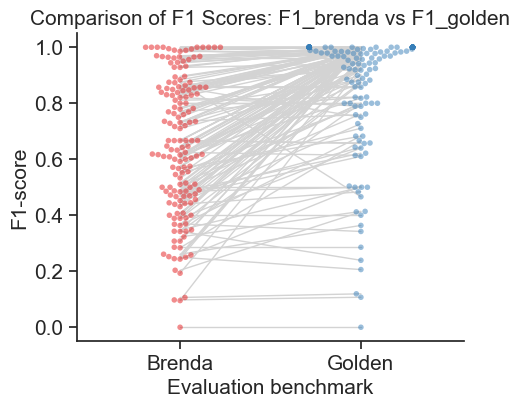

In [43]:
merged_df = process_aligned_data(brenda_3435, golden_156)
fig = plot_individual_f1_golden_f1_brenda(merged_df)
# fig.savefig('figure/fig.2g.svg', format='svg', bbox_inches='tight')
# fig.savefig('figure/fig.2g.png', format='png', dpi=300, bbox_inches='tight')